gensim学习：
https://zhuanlan.zhihu.com/p/37175253
https://blog.csdn.net/sinat_26917383/article/details/69803018

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
import jieba
from gensim.models import KeyedVectors
import warnings
warnings.filterwarnings('ignore')
import bz2

In [2]:
# with open('embeddings/sgns.zhihu.bigram','wb') as new_file,open('embeddings/sgns.zhihu.bigram.bz2','rb') as file:
#     decompressor=bz2.BZ2Decompressor()
#     for data in iter(lambda:file.read(100*1024),b''):
#         new_file.write(decompressor.decompress(data))

In [3]:
cn_model=KeyedVectors.load_word2vec_format('embeddings/sgns.zhihu.bigram',binary=False,unicode_errors='ignore')

In [21]:
embedding_dim=cn_model['山东大学'].shape[0]
embedding_dim

300

In [22]:
cn_model.similarity('橘子','橙子')

0.66128117

In [23]:
np.dot(cn_model['橘子']/np.linalg.norm(cn_model['橘子']),cn_model['橙子']/np.linalg.norm(cn_model['橙子']))

0.66128117

In [40]:
cn_model.most_similar(positive=['橘子'],topn=10)

[('圣女果', 0.6986043453216553),
 ('火龙果', 0.6928063631057739),
 ('哈密瓜', 0.6855860948562622),
 ('山竹', 0.6833729147911072),
 ('油桃', 0.682028591632843),
 ('卷心菜', 0.6734050512313843),
 ('板栗', 0.6704466938972473),
 ('百香果', 0.6689621806144714),
 ('梨子', 0.6672431230545044),
 ('桃子', 0.6646143794059753)]

In [41]:
cn_model.most_similar(positive=['橘子','橙子'],topn=10)

[('火龙果', 0.7393988370895386),
 ('哈密瓜', 0.7348312139511108),
 ('桃子', 0.7337439060211182),
 ('圣女果', 0.7326869368553162),
 ('柚子', 0.7324603796005249),
 ('山竹', 0.7232064008712769),
 ('梨子', 0.722402811050415),
 ('油桃', 0.7187268733978271),
 ('卷心菜', 0.7105546593666077),
 ('金桔', 0.7091059684753418)]

In [52]:
# import os
# pos_txts=os.listdir('pos')
# neg_txts=os.listdir('neg')

In [92]:
# print('样本总量：{}'.format(len(pos_txts)+len(neg_txts)))

样本总量：4000


In [4]:
train_texts_orig=[]
train_target=[]
with open('positive_samples.txt','r',encoding='utf-8') as f:
    lines=f.readlines()
    for line in lines:
        dic=eval(line)
        train_texts_orig.append(dic['text'])
        train_target.append(dic['label'])

with open('negative_samples.txt','r',encoding='utf-8') as f:
    lines=f.readlines()
    for line in lines:
        dic=eval(line)
        train_texts_orig.append(dic['text'])
        train_target.append(dic['label'])

In [ ]:
train_texts_orig

In [69]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,GRU,Embedding,LSTM,Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard,ReduceLROnPlateau

In [94]:
train_tokens=[]
for text in train_texts_orig:
    text=re.sub('[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+','',text)
    cut=jieba.cut(text)
    cut_list=[i for i in cut]
    for i,word in enumerate(cut_list):
        try:
            cut_list[i]=cn_model.vocab[word].index
        except KeyError:
            cut_list[i]=0
    train_tokens.append(cut_list)
                

In [137]:
train_tokens[0]

[4656,
 163,
 710,
 909,
 32,
 328,
 12,
 1899,
 18,
 8685,
 1604,
 1,
 1845,
 144,
 2420,
 153,
 36,
 75,
 3,
 1487,
 571,
 34,
 72]

In [95]:
#获取每行 分词的个数
num_tokens=[len(tokens) for tokens in train_tokens]
num_tokens=np.array(num_tokens)

In [96]:
np.mean(num_tokens)

71.4495

In [97]:
np.max(num_tokens)

1540

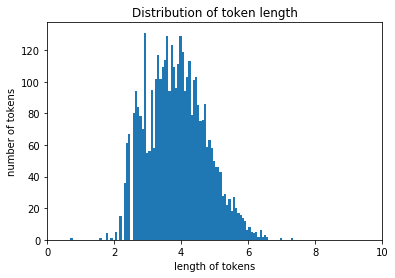

In [109]:
plt.hist(np.log(num_tokens),bins=100)
plt.xlim(0,10)
plt.ylabel('number of tokens')
plt.xlabel('length of tokens')
plt.title('Distribution of token length')
plt.show()

In [115]:
max_tokens=np.mean(num_tokens)+2*np.std(num_tokens)
max_tokens=int(max_tokens)
max_tokens

236

In [118]:
np.sum(num_tokens<max_tokens)/len(num_tokens)

0.9565

In [146]:
def reverse_tokens(tokens):
    text=''
    for i in tokens:
        if i != 0:
            text=text+cn_model.index2word[i]
        else:
            text=text+' '
    return text

In [123]:
reverse=reverse_tokens(train_tokens[2])
reverse

'CBD中心周围没什么店铺说5星有点勉强不知道为什么卫生间没有电吹风'

In [124]:
train_texts_orig[2]

'CBD中心,周围没什么店铺,说5星有点勉强.不知道为什么卫生间没有电吹风'

In [125]:
#只取字典表里使用频率最高的前50000个词的embedding,其它词按‘空格’处理
num_words=50000
embedding_matrix=np.zeros((num_words,embedding_dim))
for i in range(num_words):
    embedding_matrix[i,:]=cn_model[cn_model.index2word[i]]
embedding_matrix=embedding_matrix.astype('float32')

In [126]:
np.sum(cn_model[cn_model.index2word[333]]==embedding_matrix[333])

300

In [127]:
embedding_matrix.shape

(50000, 300)

In [132]:
train_pad=pad_sequences(train_tokens,maxlen=max_tokens,padding='pre',truncating='pre')

In [141]:
train_pad[train_pad>=num_words]=0

In [139]:
len(train_tokens[33])

83

In [140]:
train_pad[33].shape

(236,)

In [142]:
train_target=np.array(train_target)

In [143]:
from sklearn.model_selection import train_test_split

In [144]:
X_train,X_test,y_train,y_test=train_test_split(train_pad,train_target,test_size=0.1,random_state=12)

In [147]:
print(reverse_tokens(X_train[35]))
print('class:',y_train[35])

                                                                                                                                                                                                                        房间很大还有海景阳台走出酒店就是沙滩非常不错唯一遗憾的就是不能刷 不方便
class: 1


In [149]:
model=Sequential()

In [150]:
model.add(Embedding(num_words,embedding_dim,weights=[embedding_matrix],input_length=max_tokens,trainable=False))

In [151]:
model.add(Bidirectional(LSTM(units=64,return_sequences=True)))
model.add(LSTM(units=16,return_sequences=False))

In [152]:
model.add(Dense(1,activation='sigmoid'))
optimizer=Adam(lr=1e-3)

In [153]:
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [155]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 236, 300)          15000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 236, 128)          186880    
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                9280      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 15,196,177
Trainable params: 196,177
Non-trainable params: 15,000,000
_________________________________________________________________


In [156]:
path_checkpoint='sentiment_checkpoint.keras'
checkpoint=ModelCheckpoint(filepath=path_checkpoint,monitor='val_loss',verbose=1,save_weights_only=True,save_best_only=True)

In [157]:
try:
    model.load_weights(path_checkpoint)
except Exception as e:
    print(e)

Unable to open file (unable to open file: name = 'sentiment_checkpoint.keras', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


In [159]:
earlystopping=EarlyStopping(monitor='val_loss',patience=5,verbose=1)

In [160]:
lr_reduction=ReduceLROnPlateau(monitor='val_loss',factor=0.1,min_lr=1e-8,patience=0,verbose=1)

In [161]:
callbacks=[earlystopping,checkpoint,lr_reduction]

In [165]:
model.fit(X_train,y_train,validation_split=0.1,epochs=100,batch_size=128,callbacks=callbacks)

Train on 3240 samples, validate on 360 samples
Epoch 1/100
3200/3240 [============================>.] - ETA: 0s - loss: 0.2992 - accuracy: 0.8806
Epoch 00001: val_loss improved from 0.33192 to 0.33192, saving model to sentiment_checkpoint.keras
3240/3240 [==============================] - 36s 11ms/sample - loss: 0.2994 - accuracy: 0.8806 - val_loss: 0.3319 - val_accuracy: 0.8583
Epoch 2/100
3200/3240 [============================>.] - ETA: 0s - loss: 0.2977 - accuracy: 0.8813
Epoch 00002: val_loss improved from 0.33192 to 0.33192, saving model to sentiment_checkpoint.keras
3240/3240 [==============================] - 36s 11ms/sample - loss: 0.2994 - accuracy: 0.8806 - val_loss: 0.3319 - val_accuracy: 0.8583
Epoch 3/100
3200/3240 [============================>.] - ETA: 0s - loss: 0.2994 - accuracy: 0.8803
Epoch 00003: val_loss improved from 0.33192 to 0.33192, saving model to sentiment_checkpoint.keras
3240/3240 [==============================] - 36s 11ms/sample - loss: 0.2994 - accurac

Epoch 26/100
3200/3240 [============================>.] - ETA: 0s - loss: 0.3003 - accuracy: 0.8803
Epoch 00026: val_loss improved from 0.33189 to 0.33189, saving model to sentiment_checkpoint.keras
3240/3240 [==============================] - 37s 11ms/sample - loss: 0.2994 - accuracy: 0.8806 - val_loss: 0.3319 - val_accuracy: 0.8611
Epoch 27/100
3200/3240 [============================>.] - ETA: 0s - loss: 0.3005 - accuracy: 0.8803
Epoch 00027: val_loss improved from 0.33189 to 0.33189, saving model to sentiment_checkpoint.keras
3240/3240 [==============================] - 37s 11ms/sample - loss: 0.2994 - accuracy: 0.8806 - val_loss: 0.3319 - val_accuracy: 0.8611
Epoch 28/100
3200/3240 [============================>.] - ETA: 0s - loss: 0.2977 - accuracy: 0.8819
Epoch 00028: val_loss improved from 0.33189 to 0.33189, saving model to sentiment_checkpoint.keras
3240/3240 [==============================] - 36s 11ms/sample - loss: 0.2994 - accuracy: 0.8806 - val_loss: 0.3319 - val_accuracy:

3240/3240 [==============================] - 36s 11ms/sample - loss: 0.2993 - accuracy: 0.8806 - val_loss: 0.3319 - val_accuracy: 0.8611
Epoch 51/100
3200/3240 [============================>.] - ETA: 0s - loss: 0.3005 - accuracy: 0.8797
Epoch 00051: val_loss improved from 0.33185 to 0.33185, saving model to sentiment_checkpoint.keras
3240/3240 [==============================] - 36s 11ms/sample - loss: 0.2993 - accuracy: 0.8806 - val_loss: 0.3319 - val_accuracy: 0.8611
Epoch 52/100
3200/3240 [============================>.] - ETA: 0s - loss: 0.2977 - accuracy: 0.8816
Epoch 00052: val_loss improved from 0.33185 to 0.33185, saving model to sentiment_checkpoint.keras
3240/3240 [==============================] - 35s 11ms/sample - loss: 0.2993 - accuracy: 0.8806 - val_loss: 0.3318 - val_accuracy: 0.8611
Epoch 53/100
3200/3240 [============================>.] - ETA: 0s - loss: 0.2967 - accuracy: 0.8822
Epoch 00053: val_loss improved from 0.33185 to 0.33185, saving model to sentiment_checkpoin

Epoch 75/100
3200/3240 [============================>.] - ETA: 0s - loss: 0.2987 - accuracy: 0.8809
Epoch 00075: val_loss improved from 0.33182 to 0.33182, saving model to sentiment_checkpoint.keras
3240/3240 [==============================] - 38s 12ms/sample - loss: 0.2993 - accuracy: 0.8806 - val_loss: 0.3318 - val_accuracy: 0.8611
Epoch 76/100
3200/3240 [============================>.] - ETA: 0s - loss: 0.3004 - accuracy: 0.8803
Epoch 00076: val_loss improved from 0.33182 to 0.33181, saving model to sentiment_checkpoint.keras
3240/3240 [==============================] - 37s 12ms/sample - loss: 0.2993 - accuracy: 0.8806 - val_loss: 0.3318 - val_accuracy: 0.8611
Epoch 77/100
3200/3240 [============================>.] - ETA: 0s - loss: 0.2988 - accuracy: 0.8809
Epoch 00077: val_loss improved from 0.33181 to 0.33181, saving model to sentiment_checkpoint.keras
3240/3240 [==============================] - 37s 12ms/sample - loss: 0.2993 - accuracy: 0.8806 - val_loss: 0.3318 - val_accuracy:

3240/3240 [==============================] - 38s 12ms/sample - loss: 0.2993 - accuracy: 0.8799 - val_loss: 0.3318 - val_accuracy: 0.8611
Epoch 100/100
3200/3240 [============================>.] - ETA: 0s - loss: 0.2974 - accuracy: 0.8813
Epoch 00100: val_loss improved from 0.33178 to 0.33178, saving model to sentiment_checkpoint.keras
3240/3240 [==============================] - 38s 12ms/sample - loss: 0.2993 - accuracy: 0.8799 - val_loss: 0.3318 - val_accuracy: 0.8611


In [168]:
result=model.evaluate(X_test,y_test)
print('Accuracy:{0:.2%}'.format(result[1]))

400/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Accuracy:84.00%


In [169]:
print('Accuracy:{0:.2%}'.format(result[1]))

Accuracy:84.00%


In [ ]:
def predict_sentiment(text):
    

In [82]:
cn_model.vocab['橘子']

In [67]:
f=open('test.txt','r')

In [ ]:
text=[]
line=f.readline()
while line:
    text.append(line)
    line=f.readline()
text

In [113]:
np.int(3.6)

3

In [128]:
help(pad_sequences)

Help on function pad_sequences in module keras_preprocessing.sequence:

pad_sequences(sequences, maxlen=None, dtype='int32', padding='pre', truncating='pre', value=0.0)
    Pads sequences to the same length.
    
    This function transforms a list of
    `num_samples` sequences (lists of integers)
    into a 2D Numpy array of shape `(num_samples, num_timesteps)`.
    `num_timesteps` is either the `maxlen` argument if provided,
    or the length of the longest sequence otherwise.
    
    Sequences that are shorter than `num_timesteps`
    are padded with `value` at the end.
    
    Sequences longer than `num_timesteps` are truncated
    so that they fit the desired length.
    The position where padding or truncation happens is determined by
    the arguments `padding` and `truncating`, respectively.
    
    Pre-padding is the default.
    
    # Arguments
        sequences: List of lists, where each element is a sequence.
        maxlen: Int, maximum length of all sequences.
      

In [115]:
id(b)

1669430916720

In [79]:
t=jieba.cut('这是一个测试')

In [75]:
for i in t:
    print(i)

Building prefix dict from the default dictionary ...
I1223 20:21:45.334305  1928 __init__.py:111] Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
I1223 20:21:46.092200  1928 __init__.py:145] Dumping model to file cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.840 seconds.
I1223 20:21:46.175977  1928 __init__.py:163] Loading model cost 0.840 seconds.
Prefix dict has been built succesfully.
I1223 20:21:46.176974  1928 __init__.py:164] Prefix dict has been built succesfully.


这是
一个
测试


In [80]:
for i,tt in enumerate(t):
    print(i,tt)

0 这是
1 一个
2 测试


In [130]:
stack=[1,2]

In [131]:
stack.pop()

2